
$
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\vt}[1]{{\boldsymbol #1}}
$

# Prediction of sine function using LSTM

- Simple RNN example. (we use LSTM this time) 
- Train noisy sine function and predict $\sin(t+1)$ from $\sin(t)$
- Return the output of RNN (LSTM) to the input and recursively obtain the output to obtain the time series; $\sin(t+n)$

In [2]:
# check GPU availability
# if not work, enable GPU on your Colab notebook
!nvidia-smi

Thu Jun  9 12:02:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Target function

$$
f(t)=\sin(2\pi t/T)+\epsilon U(-1,1)
$$

$$
t = 1, 2, \cdots, TN+1 \\
$$ 

$U(\alpha, \beta):$ uniform distribution between $\alpha$ and $\beta$.

Preparation - generation of noisy sine function.

In [3]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
random.seed(0)
# intensity of noise; e
noise_intensity = 0.05
# number of steps per cycle; T
steps_per_cycle = 80
# number of cycles; n
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles+1), columns=["t"])
# additional one data (+1) is for the label (see later in detail)

df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * noise_intensity))


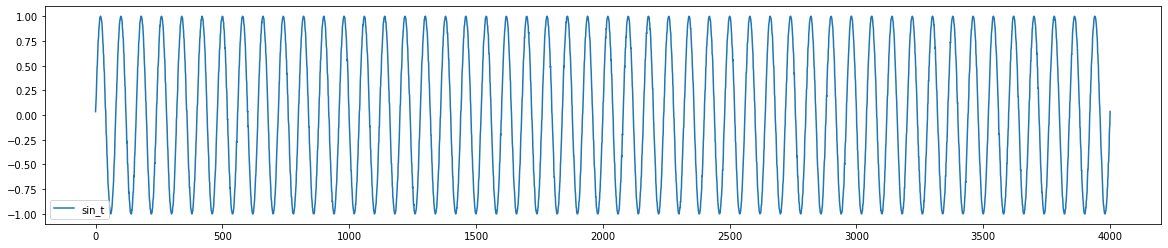

In [4]:
# plot entire function
df[["sin_t"]].plot(figsize=(20, 4))

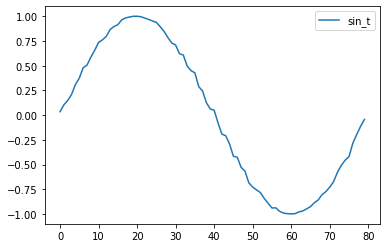

In [5]:
# plot the first one cycle
df[["sin_t"]].head(steps_per_cycle * 1).plot()

In [6]:
# check generated function (in pandas DataFrame)
# In this dataframe, t and sin_t are aligned vertically
df.info

<bound method DataFrame.info of          t     sin_t
0        0  0.034435
1        1  0.104146
2        2  0.148585
3        3  0.209938
4        4  0.310089
...    ...       ...
3996  3996 -0.354502
3997  3997 -0.193910
3998  3998 -0.127862
3999  3999 -0.097026
4000  4000  0.036441

[4001 rows x 2 columns]>

In [7]:
len(df)

4001

Split generated mother noisy sine function into the training and testing data

In [8]:
def _load_data(data, n_steps = 100):  
    """
    data should be pd.DataFrame()
    This function divides one time series into data for each n_steps.
    each docX: n_step time series data                 e.g., f(0), f(1), ...f(99)
    each docY: next output (estimation target of docX) e.g., f(100)
    """

    docX, docY = [], []
    for i in range(len(data)-n_steps):
        docX.append(data.iloc[i:i+n_steps].values)
        docY.append(data.iloc[i+n_steps].values)
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_steps = 100):  
    """
    This just splits data to training and testing parts
    """
    n_train = round(len(df) * (1 - test_size))
    n_train = int(n_train)
    X_train, y_train = _load_data(df.iloc[0:n_train], n_steps)
    X_test, y_test = _load_data(df.iloc[n_train:], n_steps)

    return (X_train, y_train), (X_test, y_test)

In [9]:
# define the sequence length 
# if you set 100, it means that one data has a length of 100.
length_of_sequences = 100
(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_steps =length_of_sequences) 

In [10]:
# check the data split
X, Y = _load_data(df)
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3901, 100, 2)
(3901, 2)


In [11]:
# check the datasize
print(type(X_train))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
(3501, 100, 1)
(300, 100, 1)
(3501, 1)
(300, 1)


[0.99991531]


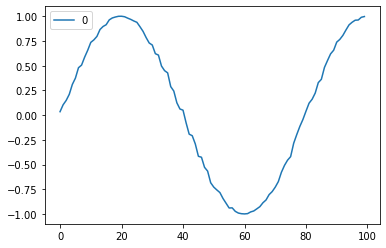

In [12]:
# sample of each training data (1st data)
# each data has a 100 contiguous data and estimate the next
pd.DataFrame(X_train[0]).plot()
print(y_train[0])

[-0.72804981]


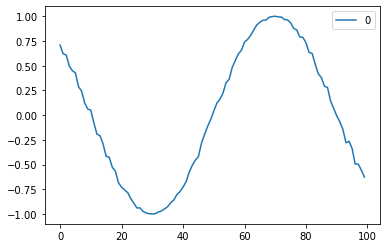

In [13]:
# sample of each training data (31st data)
pd.DataFrame(X_train[30]).plot()
print(y_train[30])

## Model definition

This model, each sequence ($\vt{x}=\{x_1, x_2, \cdots, x_{100}\}$) is converted into 64 dim representation ($\vt{h}$).

Then, 64 dim ($\vt{h}$) -> 1 dim ($y$) : fully-connected neural networks (Dence layer).

All the weights (trabable parameters; all the parameters in LSTM and fully-connected layers) are trained with back-propagation.


In [14]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_out_neurons = 1
hidden_neurons = 32

model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))

In [15]:
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


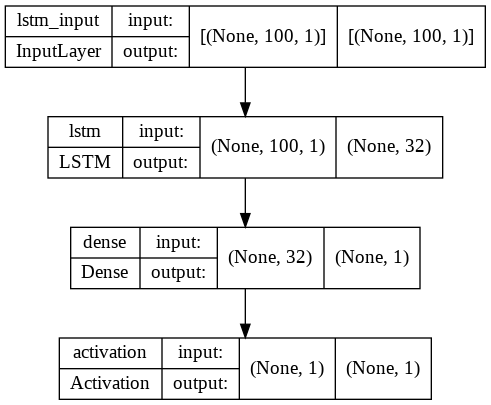

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Start training

In [18]:
# Training the model, you can use this, but you can choose with early stopping option
# this time we use 5% of the training data as the validation data (just monitor the performance)
#model.fit(X_train, y_train, batch_size=300, epochs=10, validation_split=0.05) 

In [19]:
# early stopping
# monitor the validation loss and stop if limited improvements
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, batch_size=300, epochs=10, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
12/12 [==============================] - 9s 377ms/step - loss: 0.3671 - val_loss: 0.1929
Epoch 2/10
12/12 [==============================] - 4s 358ms/step - loss: 0.1464 - val_loss: 0.0705
Epoch 3/10
12/12 [==============================] - 4s 363ms/step - loss: 0.0396 - val_loss: 0.0100
Epoch 4/10
12/12 [==============================] - 4s 354ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 5/10
12/12 [==============================] - 4s 357ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/10
12/12 [==============================] - 4s 359ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 7/10
12/12 [==============================] - 4s 355ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/10
12/12 [==============================] - 4s 345ms/step - loss: 0.0011 - val_loss: 0.0073
Epoch 9/10
12/12 [==============================] - 4s 342ms/step - loss: 0.0018 - val_loss: 6.5596e-04
Epoch 10/10
12/12 [==============================] - 4s 349ms/step - loss: 0.0016 - val_loss: 0.

## Prediction

In [20]:
predicted = model.predict(X_test) 

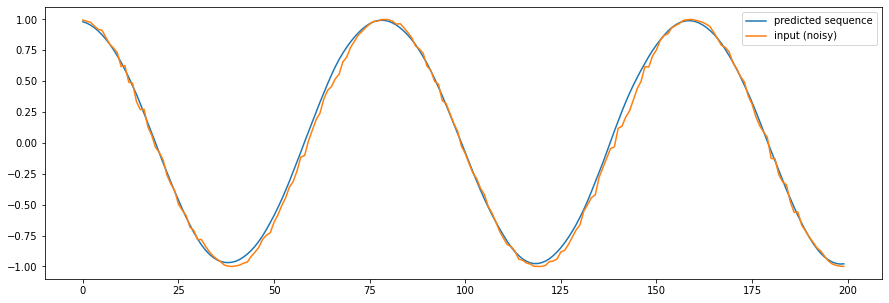

In [21]:
# visualize predicted results for test data (X_test)
dataf =  pd.DataFrame(predicted[:200])
dataf.columns = ["predicted sequence"]
dataf["input (noisy)"] = y_test[:200]
dataf.plot(figsize=(15, 5))